In [20]:
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Optimization
import optuna

# Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier

# Feature Selection & Ensembling
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Constants
RANDOM_STATE = 42
N_TRIALS = 30  # Number of Optuna trials per model
N_JOBS = -1    # Use all cores

# Paths
DATA_DIR = Path('../data')
FEATURES_DIR = Path('features')
MODELS_DIR = Path('models')
RESULTS_DIR = Path('results')
RESULTS_DIR.mkdir(exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

print(f"Python Version: {sys.version}")
print(f"Optuna Version: {optuna.__version__}")
print("Setup Complete. Ready for Step 5.")


Python Version: 3.11.14 (main, Oct 31 2025, 23:04:14) [Clang 21.1.4 ]
Optuna Version: 4.6.0
Setup Complete. Ready for Step 5.


In [21]:
# 5.1 Load Data and Features

# Load Dataframes
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df = pd.read_csv(DATA_DIR / 'val.csv')
y_train = train_df['label'].values
y_val = val_df['label'].values

# Load the Best Feature Matrix from Step 3 (Hybrid: Word + Char)
# We use this for Linear Models (SGD, SVM, NB) which handle high-dim sparse data well
import scipy.sparse as sp_sparse
X_train_hybrid = sp_sparse.load_npz(FEATURES_DIR / 'X_train_hybrid.npz')
X_val_hybrid = sp_sparse.load_npz(FEATURES_DIR / 'X_val_hybrid.npz')

print(f"Training Data Shape: {X_train_hybrid.shape}")
print(f"Validation Data Shape: {X_val_hybrid.shape}")
print(f"Labels Shape: {y_train.shape}")

Training Data Shape: (102000, 100000)
Validation Data Shape: (18000, 100000)
Labels Shape: (102000,)


In [22]:
# 5.2 Feature Selection for Tree-Based Models

# We reduce dimensionality for LightGBM to improve training speed and performance
# Linear models will keep using the full 100k set
TARGET_FEATURES = 5000

print(f"Selecting top {TARGET_FEATURES} features using Chi2 statistics...")
start_time = time.time()

selector = SelectKBest(chi2, k=TARGET_FEATURES)
X_train_selected = selector.fit_transform(X_train_hybrid, y_train)
X_val_selected = selector.transform(X_val_hybrid)

print(f"Selected Train Shape: {X_train_selected.shape}")
print(f"Selected Val Shape: {X_val_selected.shape}")
print(f"Selection Time: {time.time() - start_time:.2f}s")

# Save the selector for inference pipeline
joblib.dump(selector, MODELS_DIR / 'step5_chi2_selector.pkl')
print("Feature selector saved.")


Selecting top 5000 features using Chi2 statistics...
Selected Train Shape: (102000, 5000)
Selected Val Shape: (18000, 5000)
Selection Time: 0.90s
Feature selector saved.


In [23]:
# 5.3 Define Bayesian Optimization Objectives

def objective_sgd(trial):
    """Optimize SGDClassifier (Logistic Regression / SVM approximation)"""
    params = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-1, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'loss': trial.suggest_categorical('loss', ['modified_huber', 'log_loss']),
        # specific to elasticnet
        'l1_ratio': trial.suggest_float('l1_ratio', 0.05, 0.95) if trial.params.get('penalty') == 'elasticnet' else 0.15
    }
    
    model = SGDClassifier(
        max_iter=1000, 
        random_state=RANDOM_STATE, 
        n_jobs=N_JOBS, 
        early_stopping=True,
        **params
    )
    
    # 5-fold CV on full hybrid features
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X_train_hybrid, y_train, cv=cv, scoring='f1_macro', n_jobs=N_JOBS)
    return score.mean()

def objective_lgbm(trial):
    """Optimize LightGBM on Reduced Feature Set"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        # 'device': 'gpu',
        # 'gpu_platform_id': 0,
        # 'gpu_device_id': 0
    }
    
    model = LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1, # Limit threads per model to avoid contention
        verbose=-1,
        **params
    )
    
    # Use SELECTED features (5K) for speed and stability
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='f1_macro', n_jobs=1)
    return score.mean()

def objective_nb(trial):
    """Optimize Multinomial Naive Bayes"""
    alpha = trial.suggest_float('alpha', 1e-3, 10.0, log=True)
    model = MultinomialNB(alpha=alpha)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X_train_hybrid, y_train, cv=cv, scoring='f1_macro', n_jobs=N_JOBS)
    return score.mean()

def objective_svc(trial):
    """Optimize LinearSVC"""
    C = trial.suggest_float('C', 1e-2, 10.0, log=True)
    # LinearSVC doesn't support n_jobs, so we parallelize via cross_val_score
    model = LinearSVC(C=C, max_iter=2000, random_state=RANDOM_STATE, dual='auto')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    score = cross_val_score(model, X_train_hybrid, y_train, cv=cv, scoring='f1_macro', n_jobs=N_JOBS)
    return score.mean()

print("Optimization objectives defined.")


Optimization objectives defined.


In [24]:
# 5.4 Execute Optimization Studies

optuna.logging.set_verbosity(optuna.logging.INFO)

studies = {}
best_params = {}

N_TRIALS_LGBM = 15 

# List of models to tune
tasks = [
    ("SGD", objective_sgd),
    ("NaiveBayes", objective_nb),
    ("LinearSVC", objective_svc),
    ("LightGBM", objective_lgbm)
]

print("="*80)
print(f"STARTING HYPERPARAMETER TUNING ({N_TRIALS} trials per model)")
print("="*80)

for name, objective in tasks:
    trials = N_TRIALS_LGBM if name == "LightGBM" else N_TRIALS  
    print(f"\nRunning optimization for {name}...")
    start_ts = time.time()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=trials)

    studies[name] = study
    best_params[name] = study.best_params
    
    print(f"  Best F1: {study.best_value:.4f}")
    print(f"  Best Params: {study.best_params}")
    print(f"  Time: {time.time() - start_ts:.2f}s")

# Save best params
joblib.dump(best_params, RESULTS_DIR / 'step5_best_params.pkl')
print("\nTuning Complete. Parameters saved.")


[I 2025-11-25 11:09:02,126] A new study created in memory with name: no-name-bc38e485-0518-4773-9825-e455c8eccd04


STARTING HYPERPARAMETER TUNING (30 trials per model)

Running optimization for SGD...


[I 2025-11-25 11:09:05,476] Trial 0 finished with value: 0.9159441294093913 and parameters: {'alpha': 2.040934238948351e-05, 'penalty': 'l2', 'loss': 'log_loss'}. Best is trial 0 with value: 0.9159441294093913.
[I 2025-11-25 11:09:08,335] Trial 1 finished with value: 0.9068867092510778 and parameters: {'alpha': 2.1926871089558056e-06, 'penalty': 'l2', 'loss': 'modified_huber'}. Best is trial 0 with value: 0.9159441294093913.
[I 2025-11-25 11:09:12,650] Trial 2 finished with value: 0.9019489904516307 and parameters: {'alpha': 2.4836615947747726e-05, 'penalty': 'l1', 'loss': 'log_loss'}. Best is trial 0 with value: 0.9159441294093913.
[I 2025-11-25 11:09:17,369] Trial 3 finished with value: 0.8997832815652677 and parameters: {'alpha': 0.0001127214829460273, 'penalty': 'l1', 'loss': 'modified_huber'}. Best is trial 0 with value: 0.9159441294093913.
[I 2025-11-25 11:09:21,611] Trial 4 finished with value: 0.8460481863022948 and parameters: {'alpha': 0.0001674910901747046, 'penalty': 'l1', 

  Best F1: 0.9208
  Best Params: {'alpha': 4.947962119336253e-06, 'penalty': 'elasticnet', 'loss': 'log_loss', 'l1_ratio': 0.1013153010165367}
  Time: 111.33s

Running optimization for NaiveBayes...


[I 2025-11-25 11:10:54,166] Trial 0 finished with value: 0.904118779660932 and parameters: {'alpha': 0.001064171238556927}. Best is trial 0 with value: 0.904118779660932.
[I 2025-11-25 11:10:54,851] Trial 1 finished with value: 0.9014087303829139 and parameters: {'alpha': 0.12838171546040153}. Best is trial 0 with value: 0.904118779660932.
[I 2025-11-25 11:10:55,558] Trial 2 finished with value: 0.9023502546732717 and parameters: {'alpha': 0.053005616864101004}. Best is trial 0 with value: 0.904118779660932.
[I 2025-11-25 11:10:56,255] Trial 3 finished with value: 0.8894444241761665 and parameters: {'alpha': 7.576647112165318}. Best is trial 0 with value: 0.904118779660932.
[I 2025-11-25 11:10:56,936] Trial 4 finished with value: 0.9020481430290171 and parameters: {'alpha': 0.0654744070301976}. Best is trial 0 with value: 0.904118779660932.
[I 2025-11-25 11:10:57,622] Trial 5 finished with value: 0.9000216200237541 and parameters: {'alpha': 0.31274321385444226}. Best is trial 0 with va

  Best F1: 0.9042
  Best Params: {'alpha': 0.0011931231670689673}
  Time: 20.88s

Running optimization for LinearSVC...


[I 2025-11-25 11:11:19,636] Trial 0 finished with value: 0.9128624733951665 and parameters: {'C': 0.024980012938019085}. Best is trial 0 with value: 0.9128624733951665.
[I 2025-11-25 11:11:31,710] Trial 1 finished with value: 0.9183424890370817 and parameters: {'C': 1.3932770666136087}. Best is trial 1 with value: 0.9183424890370817.
[I 2025-11-25 11:11:38,404] Trial 2 finished with value: 0.9233064027849676 and parameters: {'C': 0.3652045317276682}. Best is trial 2 with value: 0.9233064027849676.
[I 2025-11-25 11:11:43,812] Trial 3 finished with value: 0.9224094835623493 and parameters: {'C': 0.12142731666644255}. Best is trial 2 with value: 0.9233064027849676.
[I 2025-11-25 11:11:49,059] Trial 4 finished with value: 0.9124371021610399 and parameters: {'C': 0.023168784892273822}. Best is trial 2 with value: 0.9233064027849676.
[I 2025-11-25 11:12:34,836] Trial 5 finished with value: 0.9100797855234987 and parameters: {'C': 8.36103612367723}. Best is trial 2 with value: 0.9233064027849

  Best F1: 0.9236
  Best Params: {'C': 0.24507915419346896}
  Time: 265.11s

Running optimization for LightGBM...


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-25 11:17:37,550] Trial 0 finished with value: 0.8998970240360317 and parameters: {'n_estimators': 213, 'learning_rate': 0.18008626206710693, 'num_leaves': 35, 'max_depth': 5, 'subsample': 0.6945237016120651, 'colsample_bytree': 0.8999872747088535}. Best is trial 0 with value: 0.8998970240360317.
/home/dante/Desktop/prj/news/.venv/lib/python3.11/

  Best F1: 0.9083
  Best Params: {'n_estimators': 260, 'learning_rate': 0.20613981753369892, 'num_leaves': 44, 'max_depth': 10, 'subsample': 0.667326308413759, 'colsample_bytree': 0.9302491873440469}
  Time: 2523.52s

Tuning Complete. Parameters saved.


In [25]:
# 5.5 Retrain Best Models & Generate OOF Predictions (Stacking Prep)

# Instantiate models with best params
models = {
    'SGD': SGDClassifier(
        max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS, 
        early_stopping=True, **best_params['SGD']
    ),
    'NB': MultinomialNB(**best_params['NaiveBayes']),
    # Wrap SVC in CalibratedClassifierCV to get probabilities for Stacking
    'SVC': CalibratedClassifierCV(
        LinearSVC(max_iter=2000, random_state=RANDOM_STATE, dual='auto', **best_params['LinearSVC']),
        method='sigmoid', cv=3
    ),
    'LGBM': LGBMClassifier(
        random_state=RANDOM_STATE, n_jobs=4, verbose=-1, **best_params['LightGBM']
    )
}

oof_preds = {}
test_preds = {} # For final validation

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print(f"Processing {name}...")
    
    # Select appropriate feature set
    X_train_use = X_train_selected if name == 'LGBM' else X_train_hybrid
    X_val_use = X_val_selected if name == 'LGBM' else X_val_hybrid
    
    # 1. Generate OOF Probabilities (for training meta-learner)
    # method='predict_proba' ensures we get probability columns
    oof_probs = cross_val_predict(
        model, X_train_use, y_train, cv=cv_strategy, 
        method='predict_proba', n_jobs=N_JOBS
    )
    
    # 2. Train on full data and predict on Validation (for testing meta-learner)
    model.fit(X_train_use, y_train)
    val_probs = model.predict_proba(X_val_use)
    
    # Store
    oof_preds[name] = oof_probs
    test_preds[name] = val_probs
    
    # Save individual tuned model
    joblib.dump(model, MODELS_DIR / f'step5_tuned_{name}.pkl')

print("\nOOF Generation Complete.")


Processing SGD...
Processing NB...
Processing SVC...
Processing LGBM...


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature nam


OOF Generation Complete.


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:
# 5.6 Build and Evaluate Ensembles


# Prepare Meta-Features
# We concatenate the probability outputs of all 4 models
# Shape: (N_samples, N_models * N_classes)
X_meta_train = np.hstack([oof_preds[name] for name in models.keys()])
X_meta_val = np.hstack([test_preds[name] for name in models.keys()])

print(f"Meta-Feature Shape: {X_meta_train.shape}")

# --- A. Stacking Ensemble (Meta-Learner) ---
# We use Logistic Regression to learn how to weigh the base models
meta_learner = LogisticRegression(random_state=RANDOM_STATE)
meta_learner.fit(X_meta_train, y_train)

stacking_pred = meta_learner.predict(X_meta_val)
stacking_f1 = f1_score(y_val, stacking_pred, average='macro')

# --- B. Soft Voting Ensemble ---
# Simply average the probabilities
avg_probs = np.mean([test_preds[name] for name in models.keys()], axis=0)
voting_pred = np.argmax(avg_probs, axis=1)
voting_f1 = f1_score(y_val, voting_pred, average='macro')

# --- C. Comparison with Single Best Model ---
# Find best individual model on validation set
single_scores = {}
for name, model in models.items():
    X_val_use = X_val_selected if name == 'LGBM' else X_val_hybrid
    pred = model.predict(X_val_use)
    score = f1_score(y_val, pred, average='macro')
    single_scores[name] = score

print("\nRESULTS TABLE:")
print("-" * 40)
print(f"{'Model':<20} | {'Macro-F1':<10}")
print("-" * 40)
for name, score in single_scores.items():
    print(f"{name + ' (Tuned)':<20} | {score:.4f}")
print("-" * 40)
print(f"{'Soft Voting':<20} | {voting_f1:.4f}")
print(f"{'Stacking (LogReg)':<20} | {stacking_f1:.4f}")
print("-" * 40)

# Save Meta Learner
joblib.dump(meta_learner, MODELS_DIR / 'step5_meta_learner.pkl')


Meta-Feature Shape: (102000, 16)

RESULTS TABLE:
----------------------------------------
Model                | Macro-F1  
----------------------------------------
SGD (Tuned)          | 0.9268
NB (Tuned)           | 0.9065
SVC (Tuned)          | 0.9274
LGBM (Tuned)         | 0.9120
----------------------------------------
Soft Voting          | 0.9248
Stacking (LogReg)    | 0.9295
----------------------------------------


/home/dante/Desktop/prj/news/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


['models/step5_meta_learner.pkl']

Meta-Learner Coefficients (Diagonal):
Values > 0 mean the Stacker trusts this model for this class.
               SGD        NB       SVC      LGBM
World     1.575814   -0.2811   1.15136  1.493773
Sports    1.439715  0.810591  1.556519  1.254916
Business  1.267826  0.129304  1.284509    1.1267
Sci/Tech  1.410645  0.344776  1.483867  0.696963


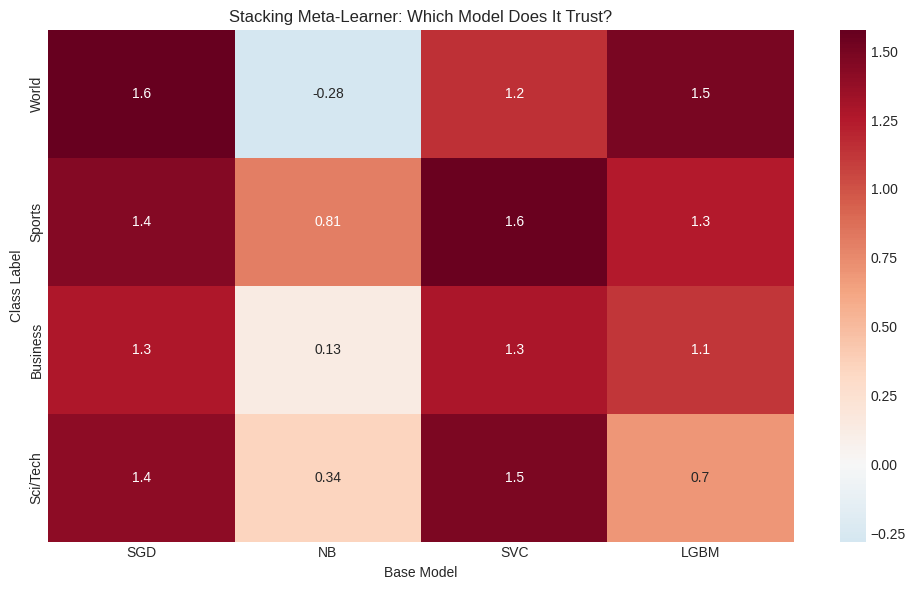


Step 5 Complete.


In [27]:
# 5.7 Meta-Learner Analysis


# The meta-learner has shape (n_classes, n_features)
# n_features = 4 models * 4 classes = 16 features
classes = ['World', 'Sports', 'Business', 'Sci/Tech']
model_names = list(models.keys())

# Create a DataFrame to visualize which model helps which class
# We sum the coefficients for the corresponding probability columns
coeffs = meta_learner.coef_ # Shape (4, 16)

importance_df = pd.DataFrame(index=classes, columns=model_names)

for i, cls in enumerate(classes):
    # The features are ordered: SGD_c0, SGD_c1... NB_c0, NB_c1...
    # We want to see how much the meta-learner weights the 'correct' class probability from each model
    for j, model in enumerate(model_names):
        # The index of the probability column for class 'i' from model 'j'
        col_idx = j * 4 + i 
        importance_df.loc[cls, model] = coeffs[i, col_idx]

print("Meta-Learner Coefficients (Diagonal):")
print("Values > 0 mean the Stacker trusts this model for this class.")
print(importance_df)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(importance_df.astype(float), annot=True, cmap='RdBu_r', center=0)
plt.title("Stacking Meta-Learner: Which Model Does It Trust?")
plt.ylabel("Class Label")
plt.xlabel("Base Model")
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'step5_stacking_weights.png')
plt.show()

print("\nStep 5 Complete.")


In [28]:
# 5.8 Overfitting & Leakage Check

results_data = []

for name, model in models.items():
    # 1. Get Training Performance (OOF Score)
    # We calculate this from the OOF predictions we generated in Cell 5.5
    # These predictions were made on data the model DID NOT see during training (per fold)
    oof_pred_labels = np.argmax(oof_preds[name], axis=1)
    oof_score = f1_score(y_train, oof_pred_labels, average='macro')
    
    # 2. Get Validation Performance
    # Predictions on the completely separate val.csv
    val_pred_labels = np.argmax(test_preds[name], axis=1)
    val_score = f1_score(y_val, val_pred_labels, average='macro')
    
    gap = oof_score - val_score
    
    status = "Good"
    if gap > 0.05: status = "Overfitting Warning"
    if gap < -0.01: status = "Possible Leakage / Distribution Mismatch"
    
    results_data.append({
        'Model': name,
        'OOF F1 (Train Estimate)': oof_score,
        'Val F1 (Actual)': val_score,
        'Gap': gap,
        'Status': status
    })

diag_df = pd.DataFrame(results_data)
print(diag_df.round(4))

print("-" * 80)
print("INTERPRETATION:")
print("1. Gap > 0.05 (5%): Model is memorizing training data. Needs regularization (higher C, alpha).")
print("2. Gap ~ 0.00 (0%): Perfect generalization.")
print("3. Gap < 0.00: Validation set might be 'easier' than training set (random chance).")


  Model  OOF F1 (Train Estimate)  Val F1 (Actual)     Gap Status
0   SGD                   0.9208           0.9268 -0.0060   Good
1    NB                   0.9042           0.9065 -0.0023   Good
2   SVC                   0.9228           0.9274 -0.0046   Good
3  LGBM                   0.9098           0.9120 -0.0022   Good
--------------------------------------------------------------------------------
INTERPRETATION:
1. Gap > 0.05 (5%): Model is memorizing training data. Needs regularization (higher C, alpha).
2. Gap ~ 0.00 (0%): Perfect generalization.
3. Gap < 0.00: Validation set might be 'easier' than training set (random chance).
